# Mount Google Drive as Folder

In [ ]:
# Require authentication
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Import

In [ ]:
# Using TF2 as Keras is integrated
%tensorflow_version 2.x
import os
import tensorflow as tf
from tensorflow import keras
import pandas as pd
from glob import glob

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model

import IPython.display as display
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

print(tf.__version__)

TensorFlow 2.x selected.
2.1.0


# Prepare directory

Augmented, undersampled dataset

In [ ]:
dataset_path = '/content/drive/My Drive/Colab Notebooks/Dataset/Preprocessed Melanoma/'
#%cd $dataset_path
#!ls
#%cd train_dir
#!ls

In [ ]:
viz_path = '/content/drive/My Drive/Colab Notebooks/Dataset/Melanoma Results Visualization'
%cd $viz_path

/content/drive/My Drive/Colab Notebooks/Dataset/Melanoma Results Visualization


Original HAM10000 

In [ ]:
# HAM10000
ham_path = '/content/drive/My Drive/skin_cancer_ham10000/skin-cancer-mnist-ham10000'
#%cd $ham_path

Checkpoint directory for VGG (Pretrained - Default)

In [ ]:
# Include the epoch in the file name
VGG_pretrained_path = "trainingVGG_Pretrained/cp-{epoch:06d}.ckpt"
VGG_pretrained_checkpoint_dir = '/content/drive/My Drive/Colab Notebooks/Checkpoint/' + VGG_pretrained_path

# Viz Time

In [ ]:
ResNet = pd.read_csv('ResNet_Dropout50.csv')
VGG = pd.read_csv('VGG_50epochs.csv')
Imb = pd.read_csv('Imbalance_frozen10epochs.csv')
Over = pd.read_csv('Oversampling_frozen10epochs.csv')
Under = pd.read_csv('Undersampling1-30.csv')

Under = Under.iloc[:10]

In [ ]:
VGG.head()

,Epochs,loss,tp,fp,tn,fn,accuracy,precision,recall,auc,val_loss,val_tp,val_fp,val_tn,val_fn,val_accuracy,val_precision,val_recall,val_auc
0,1,0.590584,20120,3402,166698,8230,0.941387,0.855369,0.709700,0.971311,0.968489,1207,496,11522,796,0.907853,0.708749,0.602596,0.928132
1,2,0.511814,21415,3099,167001,6935,0.949438,0.873582,0.755379,0.978257,0.942487,1257,450,11568,746,0.914699,0.736380,0.627559,0.932837
2,3,0.449486,22447,2778,167322,5903,0.956255,0.889871,0.791781,0.983128,0.939396,1278,446,11572,725,0.916482,0.741299,0.638043,0.935129
3,4,0.398539,23195,2550,167550,5155,0.961174,0.900952,0.818166,0.986580,0.995500,1287,486,11532,716,0.914271,0.725888,0.642536,0.932102
4,5,0.345072,24086,2173,167927,4264,0.967564,0.917247,0.849594,0.989819,1.045241,1307,534,11484,696,0.912275,0.709940,0.652521,0.931064


In [ ]:
def history_plot(df, name):
    acc = df['accuracy']
    val_acc = df['val_accuracy']

    precision = df['precision']
    val_precision = df['val_precision']

    recall = df['recall']
    val_recall = df['val_recall']

    loss = df['loss']
    val_loss = df['val_loss']

    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(acc, label='Training Accuracy', linewidth = 2)
    plt.plot(val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.ylabel('Accuracy')
    plt.ylim([0,1])
    
    plt.title(name + ' Training and Validation Accuracy')

    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(precision, label='Training Precision')
    plt.plot(val_precision, label='Validation Precision')
    plt.legend(loc='lower right')
    plt.ylabel('Precision')
    plt.ylim([0,1])
    plt.title(name + ' Training and Validation Precision')

    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(recall, label='Training Recall')
    plt.plot(val_recall, label='Validation Recall')
    plt.legend(loc='lower right')
    plt.ylabel('Recall')
    plt.ylim([0,1])
    #plt.ylim([min(plt.ylim()),1])
    plt.title(name + ' Training and Validation Recall')

    plt.subplot(2, 1, 2)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.legend(loc='lower right')
    plt.ylabel('Cross Entropy')
    plt.ylim([0,10.0])
    plt.title(name + ' Training and Validation Loss')
    plt.xlabel('epoch')
    plt.show()

In [ ]:
def history_plot_compare(vgg, resnet, name):
    acc1 = vgg['accuracy']
    val_acc1 = vgg['val_accuracy']

    acc2 = resnet['accuracy']
    val_acc2 = resnet['val_accuracy']

    precision1 = vgg['precision']
    val_precision1 = vgg['val_precision']

    precision2 = resnet['precision']
    val_precision2 = resnet['val_precision']

    recall1 = vgg['recall']
    val_recall1 = vgg['val_recall']

    recall2 = resnet['recall']
    val_recall2 = resnet['val_recall']

    loss1 = vgg['loss']
    loss2 = resnet['loss']
    val_loss1 = vgg['val_loss']
    val_loss2 = resnet['val_loss']

    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(acc1, label='Training Accuracy of VGG16')
    plt.plot(acc2, '--', label='Training Accuracy of ResNet50' )
    plt.legend(loc='lower right')
    plt.ylabel('Accuracy')
    plt.ylim([min(plt.ylim()),1])
    
    plt.title(name + ' Training Accuracy')

    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(val_acc1, label='Validation Accuracy of VGG16')
    plt.plot(val_acc2, '--', label='Validation Accuracy of ResNet50')
    plt.legend(loc='lower right')
    plt.ylabel('Accuracy')
    plt.ylim([min(plt.ylim()),1])

    # Precision

    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(precision1, label='Training Precision of VGG16')
    plt.plot(precision2, '--', label='Training Precision of ResNet50' )
    plt.legend(loc='lower right')
    plt.ylabel('Precision')
    plt.ylim([min(plt.ylim()),1])
    
    plt.title(name + ' Training Precision')

    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(val_precision1, label='Validation Precision of VGG16')
    plt.plot(val_precision2, '--', label='Validation Precision of ResNet50')
    plt.legend(loc='lower right')
    plt.ylabel('Precision')
    plt.ylim([min(plt.ylim()),1])
    
    plt.title(name + ' Validation Precision')

    # Recall

    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(recall1, label='Training Recall of VGG16')
    plt.plot(recall2, '--', label='Training Recall of ResNet50' )
    plt.legend(loc='lower right')
    plt.ylabel('Recall')
    plt.ylim([min(plt.ylim()),1])
    
    plt.title(name + ' Training Recall')

    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(val_recall1, label='Validation Recall of VGG16')
    plt.plot(val_recall2, '--', label='Validation Recall of ResNet50')
    plt.legend(loc='lower right')
    plt.ylabel('Recall')
    plt.ylim([min(plt.ylim()),1])
    
    plt.title(name + ' Validation Recall')

    # Loss

    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(loss1, label='Training Loss of VGG16')
    plt.plot(loss2, '--', label='Training Loss of ResNet50' )
    plt.legend(loc='lower right')
    plt.ylabel('Loss')
    plt.ylim([min(plt.ylim()),10])
    
    plt.title(name + ' Training Loss')

    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(val_loss1, label='Validation Loss of VGG16')
    plt.plot(val_loss2, '--', label='Validation Loss of ResNet50')
    plt.legend(loc='lower right')
    plt.ylabel('Loss')
    plt.ylim([min(plt.ylim()),10])
    
    plt.title(name + ' Validation Loss')

    plt.show()

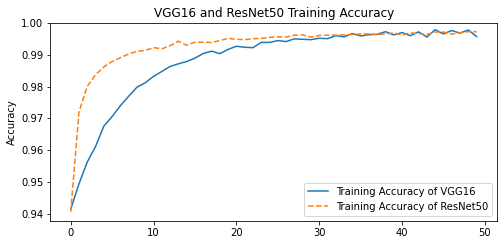

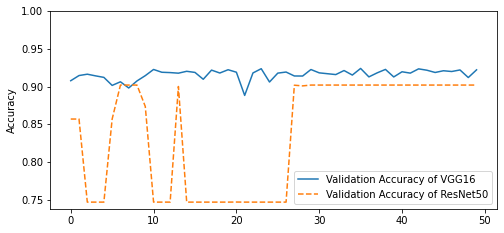

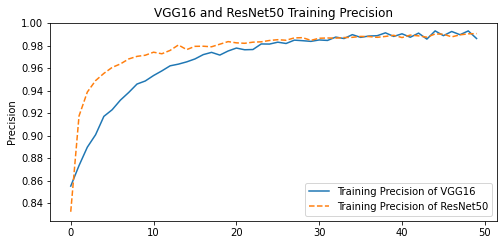

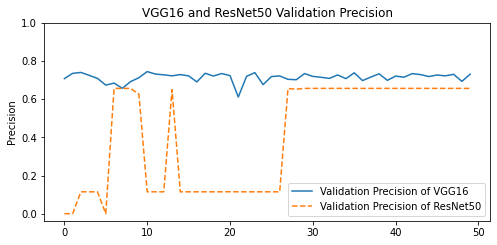

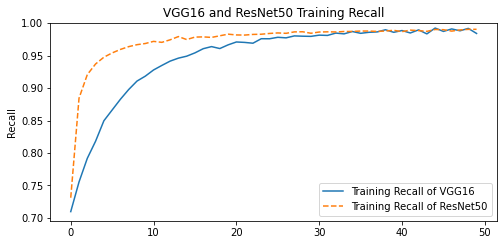

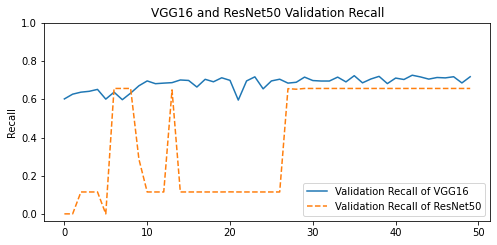

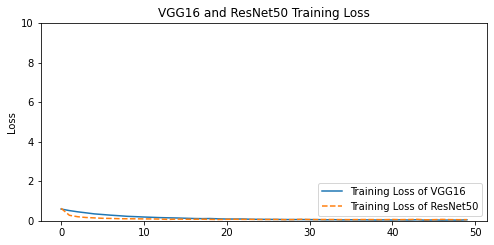

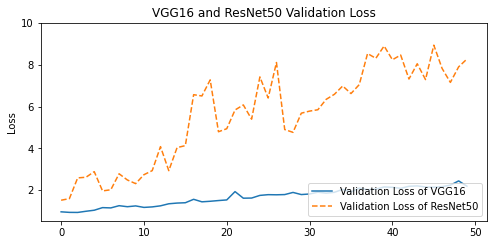

In [ ]:
history_plot_compare(VGG, ResNet, 'VGG16 and ResNet50')

In [ ]:
def history_plot_compare_3(raw, under,over , name):
    acc1 = raw['accuracy']
    acc2 = under['accuracy']
    acc3 = over['accuracy']

    val_acc1 = raw['val_accuracy']
    val_acc2 = under['val_accuracy']
    val_acc3 = over['val_accuracy']

    precision1 = raw['precision']
    precision2 = under['precision']
    precision3 = over['precision']

    val_precision1 = raw['val_precision']
    val_precision2 = under['val_precision']
    val_precision3 = over['val_precision']

    recall1 = raw['recall']
    recall2 = under['recall']
    recall3 = over['recall']

    val_recall1 = raw['val_recall']
    val_recall2 = under['val_recall']
    val_recall3 = over['val_recall']

    loss1 = raw['loss']
    loss2 = under['loss']
    loss3 = over['loss']

    val_loss1 = raw['val_loss']
    val_loss2 = under['val_loss']
    val_loss3 = over['val_loss']

    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(acc1, label='Training Accuracy of Imbalance data')
    plt.plot(acc2, '--', label='Training Accuracy of Undersampled data' )
    plt.plot(acc3, ':', label='Training Accuracy of Oversampled data' )
    plt.legend(loc='lower right')
    plt.ylabel('Accuracy')
    plt.ylim([min(plt.ylim()),1])
    
    plt.title(name + ' Training Accuracy')

    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(val_acc1, label='Validation Accuracy of Imbalance data')
    plt.plot(val_acc2, '--', label='Validation Accuracy of Undersampled data')
    plt.plot(val_acc3, ':', label='Validation Accuracy of Oversampled data' )
    plt.legend(loc='lower right')
    plt.ylabel('Accuracy')
    plt.ylim([min(plt.ylim()),1])

    # Precision

    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(precision1, label='Training Precision of Imbalance data')
    plt.plot(precision2, '--', label='Training Precision of Undersampled data' )
    plt.plot(precision3, ':', label='Training Precision of Oversampled data' )
    plt.legend(loc='lower right')
    plt.ylabel('Precision')
    plt.ylim([min(plt.ylim()),1])
    
    plt.title(name + ' Training Precision')

    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(val_precision1, label='Validation Precision of Imbalance data')
    plt.plot(val_precision2, '--', label='Validation Precision of Undersampled data')
    plt.plot(val_precision3, ':', label='Validation Precision of Oversampled data' )
    plt.legend(loc='lower right')
    plt.ylabel('Precision')
    plt.ylim([min(plt.ylim()),1])
    
    plt.title(name + ' Validation Precision')

    # Recall

    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(recall1, label='Training Recall of Imbalance data')
    plt.plot(recall2, '--', label='Training Recall of Undersampled data' )
    plt.plot(recall3, ':', label='Training Recall of Oversampled data' )
    plt.legend(loc='lower right')
    plt.ylabel('Recall')
    plt.ylim([min(plt.ylim()),1])
    
    plt.title(name + ' Training Recall')

    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(val_recall1, label='Validation Recall of Imbalance data')
    plt.plot(val_recall2, '--', label='Validation Recall of Undersampled data')
    plt.plot(val_recall3, ':', label='Validation Recall of Oversampled data' )
    plt.legend(loc='lower right')
    plt.ylabel('Recall')
    plt.ylim([min(plt.ylim()),1])
    
    plt.title(name + ' Validation Recall')

    # Loss

    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(loss1, label='Training Loss of Imbalance data')
    plt.plot(loss2, '--', label='Training Loss of Undersampled data' )
    plt.plot(loss3, ':', label='Training Loss of Oversampled data' )
    plt.legend(loc='lower right')
    plt.ylabel('Loss')
    plt.ylim([min(plt.ylim()),10])
    
    plt.title(name + ' Training Loss')

    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(val_loss1, label='Validation Loss of Imbalance data')
    plt.plot(val_loss2, '--', label='Validation Loss of Undersampled data')
    plt.plot(val_loss3, ':', label='Validation Loss of Oversampled data' )
    plt.legend(loc='lower right')
    plt.ylabel('Loss')
    plt.ylim([min(plt.ylim()),10])
    
    plt.title(name + ' Validation Loss')

    plt.show()

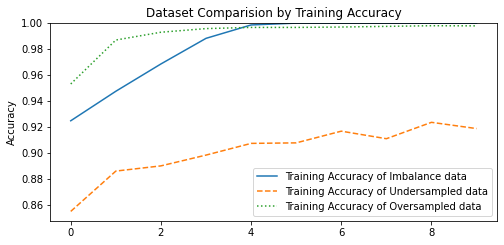

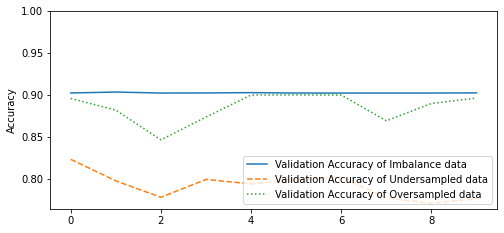

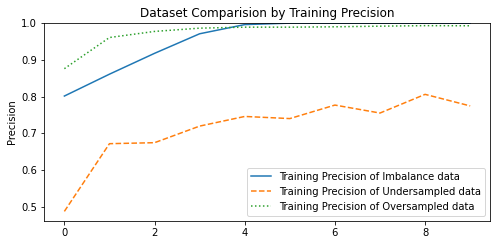

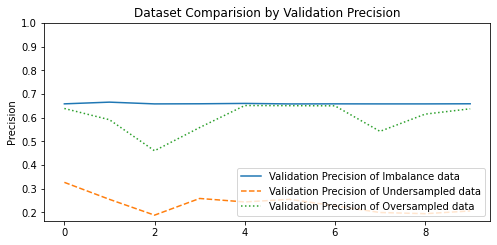

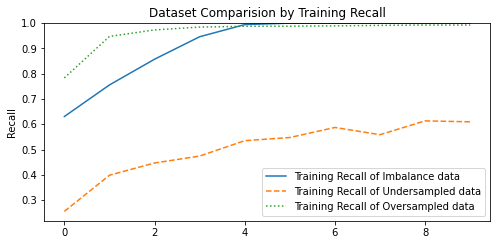

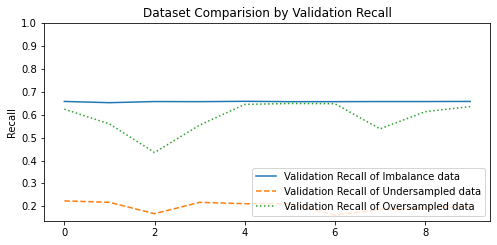

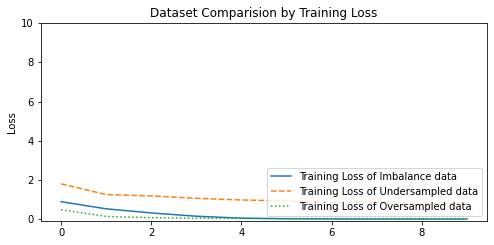

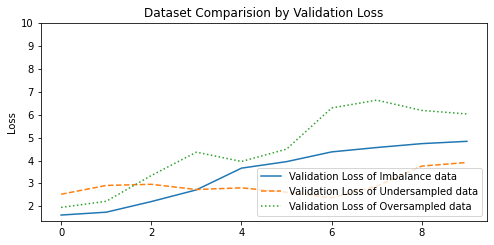

In [ ]:
 history_plot_compare_3(Imb, Under, Over, "Dataset Comparision by")

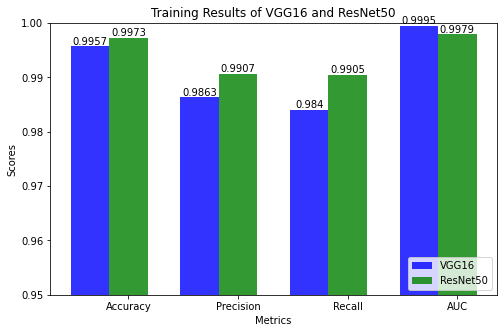

In [ ]:
# Plot bar vertical bar graph (3 graphs)

VGG_train = [0.9957,	0.9863,	0.9840,	0.9995]
ResNet_train =  [0.9973,	0.9907,	0.9905,	0.9979]
n_groups = 4

# create plot
fig, ax = plt.subplots(figsize=(8,5))

index = np.arange(n_groups)
bar_width = 0.35
opacity = 0.8

rects1 = plt.bar(index, VGG_train, bar_width,
alpha=opacity,
color='b',
label='VGG16')

rects2 = plt.bar(index + bar_width, ResNet_train, bar_width,
alpha=opacity,
color='g',
label='ResNet50')

plt.xlabel('Metrics')
plt.ylabel('Scores')
plt.title('Training Results of VGG16 and ResNet50')
plt.xticks(index + bar_width, ('Accuracy', 'Precision', 'Recall', 'AUC'))
plt.legend(loc='lower right')

plt.ylim([0.95,1])

def autolabel(rects,data):
  """
  Attach a text label above each bar displaying its height
  """
  c = 0
  initial = 0.091
  offset = 0.205
  use_global_coordinate = False

  if use_global_coordinate:
      for i in data:        
          ax.text(initial+offset*c, 0.05, str(i), horizontalalignment='center',
                  verticalalignment='center', transform=ax.transAxes,fontsize=8)
          c=c+1
  else:
      for rect,i in zip(rects,data):
          height = rect.get_height()
          ax.text(rect.get_x() + rect.get_width()/2., height,str(i),ha='center', va='bottom')

autolabel(rects1, VGG_train)
autolabel(rects2, ResNet_train)



plt.show()

<Figure size 432x288 with 0 Axes>

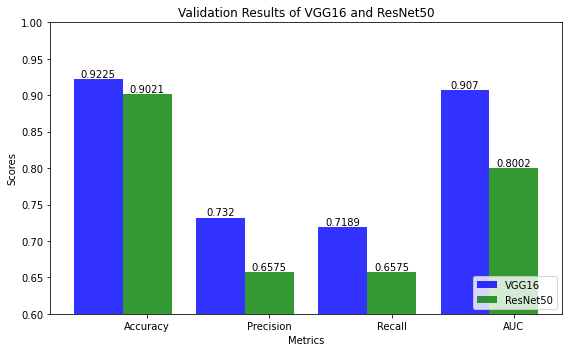

In [ ]:
# Plot bar vertical bar graph (3 graphs)

VGG_val = [0.9225,	0.7320,	0.7189,	0.9070]
ResNet_val = [0.9021,	0.6575,	0.6575,	0.8002]
n_groups = 4

plt.figure()
# create plot
fig, ax = plt.subplots(figsize=(8, 5))
#plt.figure(figsize=(8, 5))
index = np.arange(n_groups)
bar_width = 0.4
opacity = 0.8

rects1 = plt.bar(index, VGG_val, bar_width,
alpha=opacity,
color='b',
label='VGG16')

rects2 = plt.bar(index + bar_width, ResNet_val, bar_width,
alpha=opacity,
color='g',
label='ResNet50')

plt.xlabel('Metrics')
plt.ylabel('Scores')
plt.title('Validation Results of VGG16 and ResNet50')
plt.xticks(index + bar_width, ('Accuracy', 'Precision', 'Recall', 'AUC'))
plt.legend(loc='lower right')

plt.ylim([0.6,1])

def autolabel(rects,data):
  """
  Attach a text label above each bar displaying its height
  """
  c = 0
  initial = 0.091
  offset = 0.205
  use_global_coordinate = False

  if use_global_coordinate:
      for i in data:        
          ax.text(initial+offset*c, 0.05, str(i), horizontalalignment='center',
                  verticalalignment='center', transform=ax.transAxes,fontsize=8)
          c=c+1
  else:
      for rect,i in zip(rects,data):
          height = rect.get_height()
          ax.text(rect.get_x() + rect.get_width()/2., height,str(i),ha='center', va='bottom')

autolabel(rects1, VGG_val)
autolabel(rects2, ResNet_val)


plt.tight_layout()
plt.show()

<Figure size 432x288 with 0 Axes>

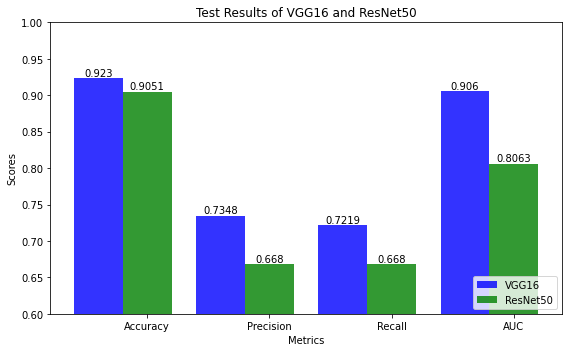

In [ ]:
# Test

VGG_test = [0.9230,	0.7348,	0.7219,	0.9060]
ResNet_test = [0.9051,	0.6680,	0.6680,	0.8063]
n_groups = 4

plt.figure()
# create plot
fig, ax = plt.subplots(figsize=(8, 5))
#plt.figure(figsize=(8, 5))
index = np.arange(n_groups)
bar_width = 0.4
opacity = 0.8

rects1 = plt.bar(index, VGG_test, bar_width,
alpha=opacity,
color='b',
label='VGG16')

rects2 = plt.bar(index + bar_width, ResNet_test, bar_width,
alpha=opacity,
color='g',
label='ResNet50')

plt.xlabel('Metrics')
plt.ylabel('Scores')
plt.title('Test Results of VGG16 and ResNet50')
plt.xticks(index + bar_width, ('Accuracy', 'Precision', 'Recall', 'AUC'))
plt.legend(loc='lower right')

plt.ylim([0.6,1])

def autolabel(rects,data):
  """
  Attach a text label above each bar displaying its height
  """
  c = 0
  initial = 0.091
  offset = 0.205
  use_global_coordinate = False

  if use_global_coordinate:
      for i in data:        
          ax.text(initial+offset*c, 0.05, str(i), horizontalalignment='center',
                  verticalalignment='center', transform=ax.transAxes,fontsize=8)
          c=c+1
  else:
      for rect,i in zip(rects,data):
          height = rect.get_height()
          ax.text(rect.get_x() + rect.get_width()/2., height,str(i),ha='center', va='bottom')

autolabel(rects1, VGG_test)
autolabel(rects2, ResNet_test)


plt.tight_layout()
plt.show()

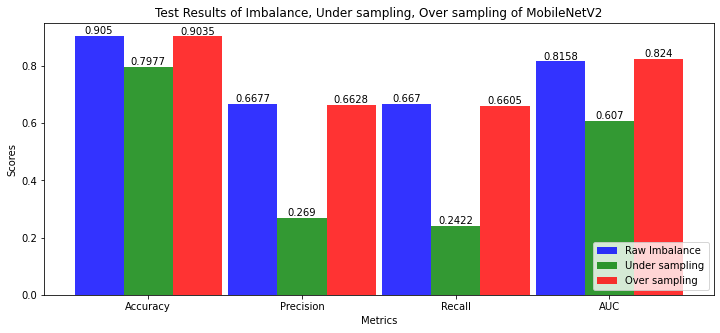

In [ ]:
# Test Results of Imbalance Data Handling

raw = [0.9050,	0.6677,	0.6670,	0.8158]
under = [0.7977, 0.2690,	0.2422,	0.6070]
over = [0.9035,	0.6628,	0.6605,	0.8240]
n_groups = 4

# create plot
fig, ax = plt.subplots(figsize=(12, 5))
index = np.arange(n_groups)
bar_width = 0.32
opacity = 0.8

rects1 = plt.bar(index, raw, bar_width,
alpha=opacity,
color='b',
label='Raw Imbalance')

rects2 = plt.bar(index + bar_width, under, bar_width,
alpha=opacity,
color='g',
label='Under sampling')

rects3 = plt.bar(index + (bar_width + bar_width), over, bar_width,
alpha=opacity,
color='r',
label='Over sampling')

plt.xlabel('Metrics')
plt.ylabel('Scores')
plt.title('Test Results of Imbalance, Under sampling, Over sampling of MobileNetV2')
plt.xticks(index + bar_width, ('Accuracy', 'Precision', 'Recall', 'AUC'))
plt.legend(loc='lower right')

#plt.ylim([0.6,1])

def autolabel(rects,data):
  """
  Attach a text label above each bar displaying its height
  """
  c = 0
  initial = 0.091
  offset = 0.205
  use_global_coordinate = False

  if use_global_coordinate:
      for i in data:        
          ax.text(initial+offset*c, 0.05, str(i), horizontalalignment='center',
                  verticalalignment='center', transform=ax.transAxes,fontsize=8)
          c=c+1
  else:
      for rect,i in zip(rects,data):
          height = rect.get_height()
          ax.text(rect.get_x() + rect.get_width()/2., height,str(i),ha='center', va='bottom')

autolabel(rects1, raw)
autolabel(rects2, under)
autolabel(rects3, over)


#plt.tight_layout()
plt.show()

<Figure size 432x288 with 0 Axes>

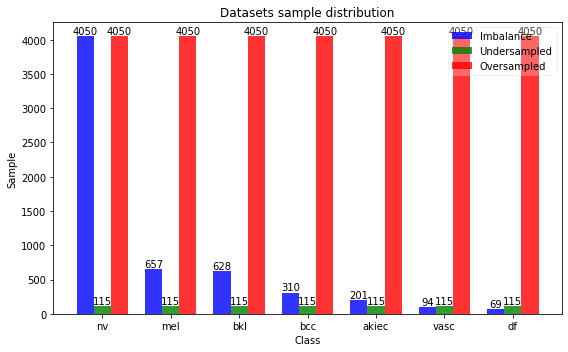

In [ ]:
# Plot bar vertical bar graph (3 graphs)

imb = [4050, 657, 628, 310, 201, 94, 69]
under = [115, 115, 115, 115, 115, 115, 115]
over = [4050, 4050, 4050, 4050, 4050, 4050, 4050]
n_groups = 7

plt.figure()
# create plot
fig, ax = plt.subplots(figsize=(8, 5))
#plt.figure(figsize=(8, 5))
index = np.arange(n_groups)
bar_width = 0.25
opacity = 0.8

rects1 = plt.bar(index, imb, bar_width,
alpha=opacity,
color='b',
label='Imbalance')

rects2 = plt.bar(index + bar_width, under, bar_width,
alpha=opacity,
color='g',
label='Undersampled')

rects3 = plt.bar(index + (2*bar_width), over, bar_width,
alpha=opacity,
color='r',
label='Oversampled')

plt.xlabel('Class')
plt.ylabel('Sample')
plt.title('Datasets sample distribution')
plt.xticks(index + bar_width, ('nv', 'mel', 'bkl', 'bcc', 'akiec', 'vasc', 'df'))
plt.legend(loc='upper right', framealpha=0.25)

#plt.ylim([0.6,1])

def autolabel(rects,data):
  """
  Attach a text label above each bar displaying its height
  """
  c = 0
  initial = 0.091
  offset = 0.205
  use_global_coordinate = False

  if use_global_coordinate:
      for i in data:        
          ax.text(initial+offset*c, 0.05, str(i), horizontalalignment='center',
                  verticalalignment='center', transform=ax.transAxes,fontsize=8)
          c=c+1
  else:
      for rect,i in zip(rects,data):
          height = rect.get_height()
          ax.text(rect.get_x() + rect.get_width()/2., height,str(i),ha='center', va='bottom')

autolabel(rects1, imb)
autolabel(rects2, under)
autolabel(rects3, over)


plt.tight_layout()
plt.show()

# keras.preprocessing (flow from dataframe)

In [ ]:
%cd $ham_path
df = pd.read_csv('HAM10000_metadata.csv')

# glob for wildcards
imageid_path = {os.path.splitext(os.path.basename(x))[0]: x
                for x in glob(os.path.join(ham_path, '*', '*.jpg'))}

df['path'] = df['image_id'].map(imageid_path.get)

lesion_type = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}
df['cell_type'] = df['dx'].map(lesion_type.get)
df['target'] = pd.Categorical(df['cell_type']).codes
df['target'] = df.target.astype(str)

# The 1./255 is to convert from uint8 to float32 in range [0,1].
# horizontal_flip=True to flip images randomly
image_generator = ImageDataGenerator(
    rescale=1./255)

BATCH_SIZE = 32
IMG_SIZE_128 = (128, 128)
#STEPS_PER_EPOCH = np.ceil(image_count/BATCH_SIZE)

train_generator = image_generator.flow_from_dataframe(
    dataframe=df,
    directory=ham_path,
    x_col="path", # x_col = file name
    y_col="target",
    batch_size=BATCH_SIZE,
    seed=42,
    shuffle=True,
    class_mode="categorical",
    target_size=(IMG_SIZE_128)
)

/content/drive/My Drive/skin_cancer_ham10000/skin-cancer-mnist-ham10000
Found 10015 validated image filenames belonging to 7 classes.


In [ ]:
df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,target,image_full_name
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,/content/drive/My Drive/skin_cancer_ham10000/s...,Benign keratosis-like lesions,2,ISIC_0027419.jpg
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,/content/drive/My Drive/skin_cancer_ham10000/s...,Benign keratosis-like lesions,2,ISIC_0025030.jpg
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,/content/drive/My Drive/skin_cancer_ham10000/s...,Benign keratosis-like lesions,2,ISIC_0026769.jpg
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,/content/drive/My Drive/skin_cancer_ham10000/s...,Benign keratosis-like lesions,2,ISIC_0025661.jpg
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,/content/drive/My Drive/skin_cancer_ham10000/s...,Benign keratosis-like lesions,2,ISIC_0031633.jpg


In [ ]:
df['cell_type'].plot(kind='barh')

In [ ]:
from sklearn.model_selection import train_test_split
Y=df.pop('dx').to_frame()
X_train, X_test, y_train, y_test   = train_test_split(df['path'],Y, test_size=0.2, random_state=42)
X_train,X_val,y_train,y_val        =train_test_split(X_train, y_train, test_size=0.25, random_state=42)

train=pd.concat([X_train,y_train],axis=1)
val=pd.concat([X_val,y_val],axis=1)
test=pd.concat([X_test,y_test],axis=1)


In [ ]:
from matplotlib.image import imread


train['image1D'] = train['path'].head().apply(lambda x: keras.preprocessing.image.load_img(x, target_size=(128,128)))



In [ ]:
train['image1D'].apply(lambda x: keras.preprocessing.image.img_to_array(x))

ValueError: ignored

In [ ]:
from scipy import ndimage
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

train_files = df['path']
dataset = []

for _file in train_files:
    img = load_img(_file)  # this is a PIL image
    #img.thumbnail((image_width, image_height))
    # Convert to Numpy Array
    x = img_to_array(img)  
    dataset.append(x)

In [ ]:
dataset

In [ ]:
from imblearn.over_sampling import SMOTE 

sm = SMOTE(sampling_strategy='auto', k_neighbors=1, random_state=42)
X_train_smote, y_train_smote = sm.fit_resample(train['X_train'], y['dx'])

KeyError: ignored

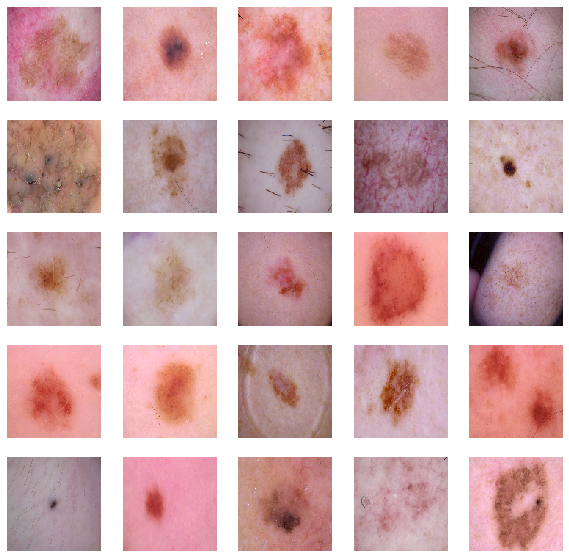

In [ ]:
def show_batch(image_batch, label_batch):
  plt.figure(figsize=(10,10))
  for n in range(25):
      ax = plt.subplot(5,5,n+1)
      plt.imshow(image_batch[n])
      #plt.title(CLASS_NAMES[label_batch[n]==1][0].title())
      plt.axis('off')
image_batch, label_batch = next(train_generator)
show_batch(image_batch, label_batch)

In [ ]:
BATCH_SIZE = 1024
IMG_SIZE_128 = (128, 128)
#STEPS_PER_EPOCH = np.ceil(image_count/BATCH_SIZE)

train_generator1024 = image_generator.flow_from_dataframe(
    dataframe=df,
    directory=ham_path,
    x_col="path", # x_col = file name
    y_col="target",
    batch_size=BATCH_SIZE,
    seed=42,
    shuffle=True,
    class_mode="categorical",
    target_size=(IMG_SIZE_128)
)

Found 10015 validated image filenames belonging to 7 classes.


# keras.preprocessing (flow from directory)

In [ ]:
IMG_SIZE = (224, 224)
dataTrain = dataset_path + 'train_dir'
dataTest = dataset_path + 'val_dir'

"""def dataGenerator(IMG_SIZE):
  train_datagen = ImageDataGenerator(rescale=1./255)
  test_datagen = ImageDataGenerator(rescale=1./255)
  train_generator = train_datagen.flow_from_directory(dataTrain, target_size=IMG_SIZE, batch_size=32, class_mode='binary')
  validation_generator = test_datagen.flow_from_directory(dataTest, target_size=IMG_SIZE, batch_size=32, class_mode='binary')
"""

train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_directory(dataTrain, target_size=IMG_SIZE, batch_size=32, class_mode='binary')
validation_generator = test_datagen.flow_from_directory(dataTest, target_size=IMG_SIZE, batch_size=32, class_mode='binary')

Found 7775 images belonging to 2 classes.
Found 223 images belonging to 2 classes.


# Callback 

In [ ]:
# Callback to save every 5 epochs?
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=?, 
    verbose=1, 
    save_weights_only=True,
    period=1)

<module 'tensorflow_core.keras.models' from '/tensorflow-2.1.0/python3.6/tensorflow_core/python/keras/api/_v2/keras/models/__init__.py'>


In [ ]:
class LossAndErrorPrintingCallback(tf.keras.callbacks.Callback):

  def on_train_batch_end(self, batch, logs=None):
    print('For batch {}, loss is {:7.2f}.'.format(batch, logs['loss']))

  def on_test_batch_end(self, batch, logs=None):
    print('For batch {}, loss is {:7.2f}.'.format(batch, logs['loss']))

  def on_epoch_end(self, epoch, logs=None):
    print('The average loss for epoch {} is {:7.2f} and mean absolute error is {:7.2f}.'.format(epoch, logs['loss'], logs['mae']))

# NOTE: to use model.fit(~~, callbacks=[LossAndErrorPrintingCallback()])
# NOTE2: Also can use with model.evaluate(~~, callbacks=[LossAndErrorPrintingCallback()])

In [ ]:
class EarlyStoppingAtMinLoss(tf.keras.callbacks.Callback):
  """Stop training when the loss is at its min, i.e. the loss stops decreasing.

  Arguments:
      patience: Number of epochs to wait after min has been hit. After this
      number of no improvement, training stops.
  """

  def __init__(self, patience=0):
    super(EarlyStoppingAtMinLoss, self).__init__()

    self.patience = patience

    # best_weights to store the weights at which the minimum loss occurs.
    self.best_weights = None

  def on_train_begin(self, logs=None):
    # The number of epoch it has waited when loss is no longer minimum.
    self.wait = 0
    # The epoch the training stops at.
    self.stopped_epoch = 0
    # Initialize the best as infinity.
    self.best = np.Inf

  def on_epoch_end(self, epoch, logs=None):
    current = logs.get('loss')
    if np.less(current, self.best):
      self.best = current
      self.wait = 0
      # Record the best weights if current results is better (less).
      self.best_weights = self.model.get_weights()
    else:
      self.wait += 1
      if self.wait >= self.patience:
        self.stopped_epoch = epoch
        self.model.stop_training = True
        print('Restoring model weights from the end of the best epoch.')
        self.model.set_weights(self.best_weights)

  def on_train_end(self, logs=None):
    if self.stopped_epoch > 0:
      print('Epoch %05d: early stopping' % (self.stopped_epoch + 1))

# NOTE: to use model.fit(~~, callbacks=[EarlyStoppingAtMinLoss(patience = ?)])

# Metrics for Classification

https://www.tensorflow.org/tutorials/structured_data/imbalanced_data

In [ ]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
]

def make_model(metrics = METRICS, output_bias=None):
  if output_bias is not None:
    output_bias = tf.keras.initializers.Constant(output_bias)
  model = keras.Sequential([
      keras.layers.Dense(
          16, activation='relu',
          input_shape=(train_features.shape[-1],)),
      keras.layers.Dropout(0.5),
      keras.layers.Dense(1, activation='sigmoid',
                         bias_initializer=output_bias),
  ])

  model.compile(
      optimizer=keras.optimizers.Adam(lr=1e-3),
      loss=keras.losses.BinaryCrossentropy(),
      metrics=metrics)

  return model

# Model

Prelimnary Information on Keras

In [ ]:
# It might be possible to freeze some part of model
# Link = https://www.tensorflow.org/api_docs/python/tf/keras/Model

MobileNet

In [ ]:
# From MobileNet Tutorial: https://towardsdatascience.com/transfer-learning-using-mobilenet-and-keras-c75daf7ff299

def MobileNetV2(img_size=None):
  # Import the mobilenetV2 model and discards the last 1000 neuron layer.
  base_model = keras.applications.mobilenet_v2.MobileNetV2(weights='imagenet',include_top=False, input_shape=img_size) 
  base_model.trainable = False
  x = base_model.output
  x = GlobalAveragePooling2D()(x)
  # Dense = FullyConnected
  x = Dense(1024,activation='relu')(x) 
  # Final layer with softmax activation
  pred_layer = Dense(7, activation='softmax')(x) 

  model = Model(inputs=base_model.input,outputs=pred_layer)
  return model
  
model = MobileNetV2((128,128,3))
model.summary()

# Adam learning rate
#opt = Adam(lr=0.001)

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Use flow from dataframe


9412608/9406464 [==============================] - 2s 0us/step
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 129, 129, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 64, 64, 32)   864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 64, 64, 32)   128         Conv1[0][0]                      
_______________________________

In [ ]:
# TPU Model
resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='grpc://' + os.environ['COLAB_TPU_ADDR'])
tf.config.experimental_connect_to_cluster(resolver)
tf.tpu.experimental.initialize_tpu_system(resolver)

strategy = tf.distribute.experimental.TPUStrategy(resolver)

with strategy.scope():
  model = MobileNetV2((128,128,3))
  model.compile(optimizer='adam',
                loss='categorical_crossentropy',
              metrics=['accuracy'])

model.fit(train_generator1024,
          epochs=1)

INFO:tensorflow:Initializing the TPU system: 10.5.138.42:8470


INFO:tensorflow:Initializing the TPU system: 10.5.138.42:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


  ...
    to  
  ['...']


  ...
    to  
  ['...']


Train for 10 steps
 1/10 [==>...........................] - ETA: 4:13

NotFoundError: ignored

In [ ]:
# History for saving log to use in later graph plotting
history = model.fit(
        train_generator,
        epochs=1,
)

  ...
    to  
  ['...']
Train for 313 steps
 32/313 [==>...........................] - ETA: 1:57:15 - loss: 1.3911 - accuracy: 0.6367

VGG11 with Pretrained (ImageNet)

In [ ]:
def VGG11_pretrained():
  # 1. Look at VGG11_scratch() below
  # 2. Read = https://medium.com/@1297rohit/transfer-learning-from-scratch-using-keras-339834b153b9

VGG11 from scratch (No pretrained)

In [ ]:
def VGG11_scratch():

  # Some part copied from = https://towardsdatascience.com/step-by-step-vgg16-implementation-in-keras-for-beginners-a833c686ae6c

  model = keras.models.Sequential()
  # Layer 1
  model.add(Conv2D(input_shape=(224,224,3), filters=64, kernel_size=(3,3), padding="same", activation="relu"))
  # Interconneted Layer: MaxPool
  model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
  # Layer 2
  model.add(Conv2D(filters=128,kernel_size=(3,3),padding="same", activation="relu"))
  # Interconneted Layer: MaxPool
  model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
  # Layer 3-4
  model.add(Conv2D(filters=256,kernel_size=(3,3),padding="same", activation="relu"))
  model.add(Conv2D(filters=256,kernel_size=(3,3),padding="same", activation="relu"))
  # Interconneted Layer: MaxPool
  model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
  # Layer 5-6
  model.add(Conv2D(filters=512,kernel_size=(3,3),padding="same", activation="relu"))
  model.add(Conv2D(filters=512,kernel_size=(3,3),padding="same", activation="relu"))
  # Interconneted Layer: MaxPool
  model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
  # Layer 7-8
  model.add(Conv2D(filters=512,kernel_size=(3,3),padding="same", activation="relu"))
  model.add(Conv2D(filters=512,kernel_size=(3,3),padding="same", activation="relu"))
  # Interconneted Layer: MaxPool
  model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))

  # Classification Output
  model.add(Flatten())
  # Layer 9-10: Fully Connected 4096
  model.add(Dense(units=4096,activation="relu"))
  model.add(Dense(units=4096,activation="relu"))
  # Layer 11: Fully Connected of 2 classes
  model.add(Dense(units=2, activation="softmax"))

  # Hench the name VGG11

  opt = Adam(lr=0.001)
  model.compile(optimizer=opt, loss=keras.losses.categorical_crossentropy, metrics=['accuracy'])
  
  return model

vgg11 = VGG11()  
vgg11.summary()

saveWeightsCallback


# Fit with simple callbacks
"""
earlyStopCallback = tf.keras.callbacks.EarlyStopping(monitor='val_acc', min_delta=0, patience=20, verbose=1, mode='auto')

model.fit(
        train_generator,
        epochs=50,
        validation_data=validation_generator,
        callbacks=[early])"""

# Fit the model  
""" model.fit_generator(
        train_generator,
        steps_per_epoch=2000,
        epochs=50,
        validation_data=validation_generator,
        validation_steps=800) 
"""

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_18 (Conv2D)           (None, 224, 224, 64)      1792      
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 112, 112, 128)     73856     
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 56, 56, 128)       0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 56, 56, 256)       295168    
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 56, 56, 256)       590080    
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 28, 28, 256)      

' model.fit_generator(\n        train_generator,\n        steps_per_epoch=2000,\n        epochs=50,\n        validation_data=validation_generator,\n        validation_steps=800) \n'

VGG16 from Keras.application

In [ ]:
"""
include_top (True): Whether or not to include the output layers for the model. You don’t need these if you are fitting the model on your own problem.
weights (‘imagenet‘): What weights to load. You can specify None to not load pre-trained weights if you are interested in training the model yourself from scratch.
input_tensor (None): A new input layer if you intend to fit the model on new data of a different size.
input_shape (None): The size of images that the model is expected to take if you change the input layer.
pooling (None): The type of pooling to use when you are training a new set of output layers.
classes (1000): The number of classes (e.g. size of output vector) for the model.


def modelVGG16():
  VGG16 = tf.keras.applications.vgg16.VGG16(include_top=False, weights='imagenet', classes=2, pooling='max')
  return VGG16"""

In [ ]:
# https://ieeexplore.ieee.org/document/8652304
# For using with SMOTE and ADOSYN
model = keras.models.Sequential()
model.add(Conv2D(input_shape=(28,28,3), filters=32, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=64, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))

model.add(Flatten())
model.add(Dense(units=128,activation="relu"))
model.add(Dense(units=2,activation="relu"))



# TODO
1. Save weights every 30 minutes
2. Custom models (VGG-11, ResNet34)


---


# From 'canary' version


1.   Find a solution for imbalanced dataset
2.   Find a solution for segmented dataset without having to retrain the whole
3.   Saving a trained model to Drive, for future training instances
4.   Validation and KFold
5.   Merge mutli-class to binary classification
6.   Implement VGG-11?, ResNet34
7.   EfficientNet?
8.   Transfer Learning
9.   Morphological Dilation with OpenCV for Segmentation paper
10.  Model Compression? (Network Pruning, ..)

# Phil's Suggestion

1. Downsampling non-melanoma (but the total data will have only 2000)
2. Use the segmented-available dataset from the start (but the total data will have only 2000)

1, 2 will need data augmentation for more samples 

# Phil's To Read

## Batch Size, Epoch, Steps

1. https://datascience.stackexchange.com/questions/29719/how-to-set-batch-size-steps-per-epoch-and-validation-steps

## Transfer Learning

1. https://www.tensorflow.org/tutorials/images/transfer_learning

## Deep Model Compression

1. https://datalab.snu.ac.kr/~ukang/talks/19-BigComp19-tutorial/DeepModelCompression-2.pdf

2. https://medium.com/zylapp/deep-learning-model-compression-for-image-analysis-methods-and-architectures-398f82b0c06f